<a href="https://colab.research.google.com/github/waadshaher/image-classification/blob/main/Beans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Model To Recognize And Classify Beans Into Their Appropriate Classes.


*Names: Waad, syabil, tazin*

In [ ]:
import tensorflow as tf
import os
import numpy as np

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Load the Data From Beans Dataset

Download the beans dataset then place it into a directory variable. Here, the training set is downloaded.

In [ ]:
_URL = 'https://storage.googleapis.com/ibeans/train.zip'
zip_dir = tf.keras.utils.get_file('train.zip', origin=_URL, extract=True)


base_dir = os.path.join(os.path.dirname(zip_dir), 'train')

143818752/143812152 [==============================] - 2s 0us/step


While here, the validation set is downloaded

In [ ]:
_TESTURL = "https://storage.googleapis.com/ibeans/validation.zip"

zip_file_val = tf.keras.utils.get_file(origin=_TESTURL, 
                                   fname="validation.zip", 
                                   extract=True)

base_dir_val = os.path.join(os.path.dirname(zip_file_val), 'validation')

18505728/18504213 [==============================] - 0s 0us/step


## Preprocess the Loaded Data

`ImageDataGenerator` class is used for the purpose of rescaling the input images from both training and validation splits, in this way, new images are created, or generated, that would be used as inputs too.

The value from the class is saved to these variables.

Convinence variables are also created (`IMAGE_SIZE`,`BATCH_SIZE`), these would be used in the next step.

In [ ]:
train_image_generator      = ImageDataGenerator(rescale=1./255) 
validation_image_generator = ImageDataGenerator(rescale=1./255)  
IMAGE_SIZE = 224
BATCH_SIZE = 64

The train generator is created and as parameters listed: the train dataset directory, image size, batch size, target size, and shuffle. Shuffle is set to true because during training, we would want the training images to be shuffled at each iteration.

`flow_from_directory()` method is used, this is to use the `ImageDataGenerator` class using the variables created in the previous step.


In [ ]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=base_dir,
                                                           shuffle=True,
                                                           target_size=(IMAGE_SIZE,IMAGE_SIZE) 
                                                           )

Found 1034 images belonging to 3 classes.


Validation generator is created with almost the same approach, the difference here, shuffle is set to false, since there is no need to shuffle the images during validation, and the directory is set to the validation directory evidently. 

In [ ]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=base_dir_val,
                                                              shuffle=False,
                                                              target_size=(IMAGE_SIZE,IMAGE_SIZE), 
                                                              )

Found 133 images belonging to 3 classes.


##Creating the Base Model from Google's MobileNetV2

`IMAGE_SHAPE` is created as a convenience variable as well, taking in the unified `IMAGE_SIZE` for all images. 3 in the parameter is explained because simply computers interpret colored images as 3D arrays, 3 representing width, height, and depth.

Next the base model is created **MobileNet V2** model. It takes the following parameters: `input_shape`, `include_top`, `weights`.

*  `input_shape`: simply takes the unified sizes of the input images as input. Images need to be resized to one unified size since our NN requires a fixed size of inputs. 

*  `include_top`: is set to false because since we need the base model to work as a feature exractor, therefore the parameter is set to false so it does not include the model's classification layers at the top.

*  `weights`: using the ImageNet weights.


In [ ]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


##Modifying V2 Model

### Set Feature Extraction Method From V2's Model

To be able to use the above model as a feature extractor only, it is set to `False`

In [ ]:
base_model.trainable = False

### Add the Convolutional Layer

After the base model has been set to false, a custom classifier can be added using `tf.keras.Sequential`.

First the base model is added. A convolutional layer is added with activation function relu.

Dropout is also performed to avoid overfitting, set to probability of 0.2, or 20%, that each neuron gets dropped.

A pooling layer is added using `GlobalAveragePooling2D()` to perform pooling.

Finally, a fully connected layer is added with 3 units (corresponding to 3 classes of the dataset) with softmax activation function.


In [ ]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(3, activation='softmax')
])

## Compile the Model

Before the model is trained, it must be compiled using the following `compile()` method. The parameters listed: 

*   `optimizer`: Using `Adam()` optimizer with default learning rate of 0.001
*   `loss`: Using a categorical cross-entropy loss, since there are several classes.
*   `metrics`: Since we would want to see the training and validation accuracies, the metrics is set to accuracy.



In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

We can check the model's layers along with their information using `summary()` method.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 99        
Total params: 2,626,755
Trainable params: 368,771
Non-trainable params: 2,257,984
_________________________________________________________________


## Train the Model

With 100 epochs set, and using the previous generators created earlier, the model can now be finally trained.

In [ ]:
epochs = 100

history = model.fit(train_data_gen, 
                    steps_per_epoch=len(train_data_gen), 
                    epochs=epochs, 
                    validation_data=val_data_gen, 
                    validation_steps=len(val_data_gen))

Epoch 1/100
17/17 [==============================] - 43s 497ms/step - loss: 3.7773 - accuracy: 0.3870 - val_loss: 0.8499 - val_accuracy: 0.5564
Epoch 2/100
17/17 [==============================] - 7s 428ms/step - loss: 0.8082 - accuracy: 0.5875 - val_loss: 0.5918 - val_accuracy: 0.6617
Epoch 3/100
17/17 [==============================] - 7s 410ms/step - loss: 0.5399 - accuracy: 0.7385 - val_loss: 0.4248 - val_accuracy: 0.7895
Epoch 4/100
17/17 [==============================] - 7s 415ms/step - loss: 0.3720 - accuracy: 0.8472 - val_loss: 0.3544 - val_accuracy: 0.8421
Epoch 5/100
17/17 [==============================] - 7s 410ms/step - loss: 0.3153 - accuracy: 0.8465 - val_loss: 0.3354 - val_accuracy: 0.8571
Epoch 6/100
17/17 [==============================] - 7s 410ms/step - loss: 0.2791 - accuracy: 0.8775 - val_loss: 0.2928 - val_accuracy: 0.8872
Epoch 7/100
17/17 [==============================] - 7s 410ms/step - loss: 0.2178 - accuracy: 0.9223 - val_loss: 0.3491 - val_accuracy: 0.819

## Plotting the Results

 We can plot the results using `matplotlib`'s help. Here we can specify what we want to translate the results from the previous step into graphs.

In the following 2 graphs, we can see the training and validation accuracies, as well as the training and validation losses. 

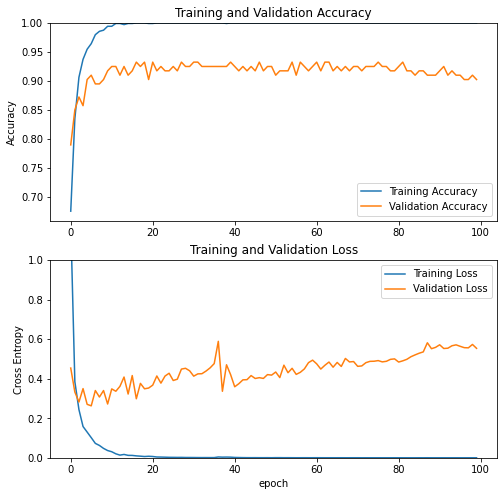

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()